In [255]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import copy
from tqdm import tqdm
import torch.optim.lr_scheduler as sched
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import os

In [256]:
root = os.getcwd()
data_root = os.path.join(root, 'data')

### Prepare Data

In [319]:
train_X = pickle.load(open(os.path.join(data_root, 'train_X.pickle'), "rb"))
train_y = pickle.load(open(os.path.join(data_root, 'train_y.pickle'), "rb"))
test_X = pickle.load(open(os.path.join(data_root, 'test_X.pickle'), "rb"))
test_y = pickle.load(open(os.path.join(data_root, 'test_y.pickle'), "rb"))

In [320]:
unlabeled_X = pickle.load(open(os.path.join(data_root, 'scaled_unlabeled_X.pickle'), "rb"))
unlabeled_y = pickle.load(open(os.path.join(data_root, 'unlabeled_y.pickle'), "rb"))

In [321]:
unlabeled_y['hospital_death'] = 0

In [323]:
train_X.shape

(73370, 411)

In [324]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ICUDataset(Dataset):
    
    def __init__(self, input_array, label_df):
        # Args:
        #      input_array: list of list
        #      label_array: list of list
        
        super(ICUDataset, self).__init__()
        self.input_tensors = []
        self.labels = torch.tensor(list(label_df.iloc[:,-1]), dtype=torch.long)
        for sample in input_array:
            self.input_tensors.append(torch.tensor([sample[:]], dtype=torch.float))
        
    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, index):
        x = self.input_tensors[index]
        # want to have y as tensor([1]), for 1 being class
        y = self.labels[index]
                   
        return x, y

In [325]:
data_train = ICUDataset(train_X, train_y)
data_test = ICUDataset(test_X, test_y)

In [326]:
data_unlabeled = ICUDataset(unlabeled_X, unlabeled_y)

In [327]:
# Test data train
x, y = next(iter(data_train))
x.shape
#y.shape

torch.Size([1, 411])

In [328]:
data_train_loader = DataLoader(data_train, batch_size = 64, shuffle=False, num_workers=4)
data_test_loader = DataLoader(data_test, batch_size = 64, shuffle=False, num_workers=4)

In [329]:
data_unlabeled_loader = DataLoader(data_unlabeled, batch_size = 64, shuffle=False, num_workers=4)

In [330]:
# We want to have x.shape = [batch_size, height, width = len of input]
# y.shape = [batch_size, 1] because y is a class
x, y = next(iter(data_train_loader))

In [331]:
y.shape

torch.Size([64])

#### 1. MLP Model

In [497]:
class MLPNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = x.contiguous().view(-1,input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


### Train and Valid

In [509]:
def train(model, data_train_loader, data_train, optimizer, criterion):
    y_true_list_train = []
    y_pred_list_train = []
    y_score_list_train = []
    num_correct = 0
    cur_loss = 0
    losslisttrain = []
    
    model.train()
    
    for iter_, (inputs, targets) in enumerate(data_train_loader):
#         if iter_ % 500 == 0:
#             print("Train Phase: Iteration {}/{}".format(iter_+1, len(data_train_loader)))

        # zero out the parameter gradients
        optimizer.zero_grad()

        # Setup for forward
        inputs = inputs.to(device)
        targets = targets.to(device)
        batch_size = inputs.size(0)


        # Feed forward to get the logits
        logit = model(inputs)
        loss = criterion(logit, targets)
        loss_val = loss.item()
        cur_loss += loss_val * batch_size
        #print('cur_loss', cur_loss)

        # Add y_true and y_pred to list to calculate AUC score
        y_true_list_train += targets.data.tolist()
        y_pred = logit.argmax(dim=1)
        y_pred_list_train += y_pred.data.tolist()
        num_correct += (y_pred == targets).sum().item()
        
        y_score_list_train += F.softmax(logit).data.numpy()[:, 1].tolist()

        # Backward
        loss.backward()
        optimizer.step()


    avg_train_loss = cur_loss / len(data_train)
    losslisttrain.append(avg_train_loss)

    train_auc =  roc_auc_score(y_true=(np.array(y_true_list_train)==1),
                               y_score=np.array(y_score_list_train))


    train_acc = (num_correct / len(data_train)) * 100 
#     print(f'Train Loss: {avg_train_loss:.4f}')
#     print(f'Train AUC: {train_auc:.4f}')
#     print(f'Train ACC: {train_acc:.4f}')

    return(avg_train_loss, train_auc, train_acc,
           model)

In [510]:
def test(model, data_test_loader, data_test):
    y_true_list_test = []
    y_pred_list_test = []
    y_score_list_test = []
    num_correct = 0
    cur_loss = 0
    losslisttest = []
    
    model.eval()
    
    for iter_, (inputs, targets) in enumerate(data_test_loader):
#         if iter_ % 500 == 0:
#             print("Valid Phase: Iteration {}/{}".format(iter_+1, len(data_test_loader)))
        # Setup for forward
        inputs = inputs.to(device)
        targets = targets.to(device)
        batch_size = inputs.size(0)

        # Feed forward to get the Logit
        logit = model(inputs)
        loss = criterion(logit, targets)
        loss_val = loss.item()
        cur_loss += loss_val * batch_size
        #print('cur_loss', cur_loss)

        # Add y_true and y_pred to list to calculate AUC score
        y_true_list_test += targets.data.tolist()
        y_pred = logit.argmax(dim=1)
        y_pred_list_test += y_pred.data.tolist()
        num_correct += (y_pred == targets).sum().item()
        y_score_list_test += F.softmax(logit).data.numpy()[:, 1].tolist()



    avg_test_loss = cur_loss / len(data_test)
    losslisttest.append(avg_test_loss)

    test_auc =  roc_auc_score(y_true=(np.array(y_true_list_test)==1),
                              y_score=np.array(y_score_list_test))


    test_acc = (num_correct / len(data_test)) * 100 
#     print(f'Valid Loss: {avg_test_loss:.4f}')
#     print(f'Valid AUC: {test_auc:.4f}')
#     print(f'Valid ACC: {test_acc:.4f}')

    return(avg_test_loss, test_auc, test_acc)

In [511]:
def train_valid(model, data_train_loader, data_train, optimizer, criterion,
                data_test_loader, data_test, num_epochs):
    best_val_loss = 1000
    best_weights = copy.deepcopy(model.state_dict())
    history_train = {'loss': [], 'acc': [], 'auc': []}
    history_test = {'loss': [], 'acc': [], 'auc': []}

    for epoch in range(num_epochs):
        if epoch % 20 == 0:
            print(epoch)
        avg_train_loss, train_auc, train_acc, model = train(model, data_train_loader,
                                                            data_train, optimizer, criterion)
        avg_test_loss, test_auc, test_acc = test(model, data_test_loader, data_test)
        history_train['loss'].append(avg_train_loss)
        history_train['auc'].append(train_auc)
        history_train['acc'].append(train_acc)
        history_test['loss'].append(avg_test_loss)
        history_test['auc'].append(test_auc)
        history_test['acc'].append(test_acc)
        
        
        
        if avg_test_loss < best_val_loss:
            best_val_loss = avg_test_loss
            best_weights = copy.deepcopy(model.state_dict())
            
        #print('-'*20)
    return (best_weights, history_train, history_test)

In [512]:
def plot_train_test(history_train, history_test):
    fig, axes = plt.subplots(ncols=3, figsize=(9, 4))
    for ax, metric in zip(axes, ['loss', 'acc', 'auc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    fig.tight_layout(pad=0.5)
    plt.show()

### Training and Validating


In [550]:
# nn package also has different loss functions.
# we use NLLLoss to 
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.NLLLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
# built-in L2
learning_rate = 0.0015
lambda_l2 = 1e-5

input_size = train_X.shape[1]
hidden_size = 200
output_size = 2

model = MLPNet(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 
num_epochs = 160

In [551]:
1e-3


0.001

In [552]:
best_weights_fc, history_train_fc, history_test_fc = train_valid(model, data_train_loader, data_train,
                                         optimizer, criterion,
                                         data_test_loader, data_test, num_epochs)

0
20
40
60
80
100
120
140


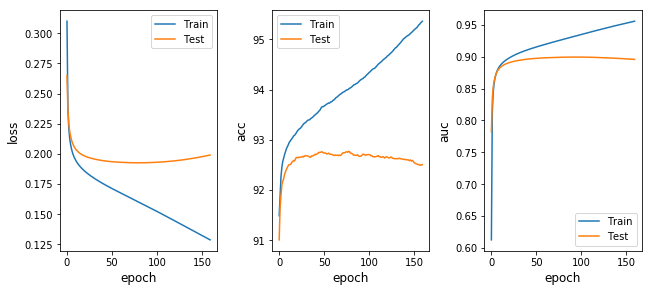

In [553]:
plot_train_test(history_train_fc, history_test_fc)

In [555]:
max(history_test_fc['auc'])

0.8994094959630872

### Train on the whole dataset

### Evaluation on Unlabeled Set


In [556]:
def evaluate(model, data_loader):

    y_score_list_test = []
    
    model.eval()
    
    for iter_, (inputs, targets) in enumerate(data_loader):
#         if iter_ % 500 == 0:
#             print("Valid Phase: Iteration {}/{}".format(iter_+1, len(data_test_loader)))
        # Setup for forward
        inputs = inputs.to(device)
        targets = targets.to(device)
        batch_size = inputs.size(0)

        # Feed forward to get the Logit
        logit = model(inputs)
        y_score_list_test += F.softmax(logit).data.numpy()[:, 1].tolist()


    return(y_score_list_test)

In [557]:
best_mlp = MLPNet(input_size, hidden_size, output_size)
best_mlp.load_state_dict(best_weights_fc)
best_mlp.eval()

MLPNet(
  (fc1): Linear(in_features=411, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
)

In [558]:
inputs, target = next(iter(data_unlabeled_loader))
logit = best_mlp(inputs)

In [559]:
data_unlabeled.__len__()

39308

In [560]:
y_unlabeled_score = evaluate(best_mlp, data_unlabeled_loader) 


In [561]:
unlabeled_X_df = pickle.load(open(os.path.join(data_root, 'unlabeled_X.pickle'), "rb"))

In [562]:
submission_df = unlabeled_X_df[['encounter_id']]

In [563]:
submission_df['hospital_death'] = y_unlabeled_score 

In [564]:
submission_df.to_csv(os.path.join(data_root, 'submission.csv'), index=False)

#### 2. 1D Convolutional Network

In [253]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature1, n_feature2, 
                 hidden_size, output_size):
        super(CNN, self).__init__()
        self.n_feature1 = n_feature1
        self.n_feature2 = n_feature2
        self.conv1 = nn.Conv1d(in_channels=input_size,
                               out_channels=n_feature1, 
                               kernel_size = 5)
        self.conv2 = nn.Conv1d(in_channels=n_feature1,
                               out_channels=n_feature2, 
                               kernel_size = 5)
        self.fc1 = nn.Linear(50 * 100, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, verbose=False):
        # After conv1, 
        # shape: (batch_size, n_feature1, o1)
        # o1 = ((input_len - kernel_size + 2P) / S + 1))
        x = self.conv1(x)
        x = F.relu(x)
        # After maxpool
        # shape = (batch_size, n_feature1, 1/2 * o1)
        x = F.max_pool1d(x, kernel_size=2)
        # After conv2, 
        # shape = (batch_size, n_feature2, o2 )
        # o2 = (o1 - kernel_size + 2P) / S + 1
        x = self.conv2(x)
        x = F.relu(x)
        # After maxpool,
        # shape = (batch_size, n_feature2, o2/2)
        x = F.max_pool1d(x, kernel_size=2)
        
        x = x.view(-1, 50 * 100)
        # After fc1, 
        # shape: (o3, hidden_size)
        # o3 = 50 * 1000. When we flat it for view, we want to keep the 
        # batch size, so we need to find that o3 dimension. In this case, it is 50 * 1000
        x = self.fc1(x)
        x = F.relu(x)
        # After fc2, 
        # shape: (hidden_size, output_size)
        x = self.fc2(x)
        
        return x

In [238]:
input_size = 1
n_feature1 = 200
n_feature2 = 50
hidden_size = 30
output_size = 2

criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
# built-in L2
learning_rate = 1e-3
lambda_l2 = 1e-5

model = CNN(input_size=1, n_feature1=200, n_feature2=50, 
           hidden_size = 30, output_size=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 
num_epochs = 2

In [250]:
x.shape

torch.Size([64, 1, 412])

In [251]:
model(x).shape

torch.Size([64, 2])

In [252]:
best_weights, history_train, history_test = train_valid(model, data_train_loader, data_train,
                                         optimizer, criterion,
                                         data_test_loader, data_test, num_epochs)

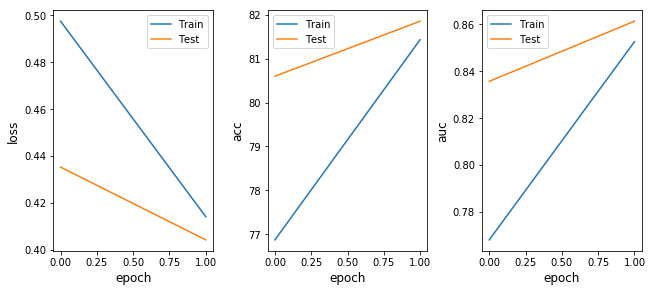

In [254]:
plot_train_test(history_train, history_test)

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true_list_train))[:, i], 
                                  np.array(pd.get_dummies(y_pred_list_train))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])